## Finding the best images from the Generative VAE model

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
# import torch.optim as optim
# import torch.utils.data as data
# from torchvision import transforms
# import torch.nn.functional as F
# from livelossplot import PlotLosses

# from torch.utils.data import Dataset, DataLoader, random_split, Subset
# import os
# from PIL import Image
# from torchvision.transforms import Compose, ToTensor
# from torchvision.transforms.functional import to_tensor
# import torch.distributions as dist
# from tqdm import tqdm

In [2]:
from src.generative.model import VAE

In [16]:
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter

In [3]:
# pip install skimage
!pip install scikit-image

  Using cached scikit_image-0.23.2-cp311-cp311-macosx_12_0_arm64.whl.metadata (14 kB)
  Using cached imageio-2.34.1-py3-none-any.whl.metadata (4.9 kB)
  Using cached tifffile-2024.5.22-py3-none-any.whl.metadata (30 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
Using cached scikit_image-0.23.2-cp311-cp311-macosx_12_0_arm64.whl (13.3 MB)
Using cached imageio-2.34.1-py3-none-any.whl (313 kB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached tifffile-2024.5.22-py3-none-any.whl (225 kB)


### Loading in the Sensor Data

In [96]:
# Loading in the Observation Data
obs_dataset = 'Data/Ferguson_fire_obs.npy' 
obs_dataset = np.load(obs_dataset)
print(obs_dataset.shape)
obs_dataset_last = obs_dataset[-1:,]
obs_dataset_last.shape

(5, 256, 256)


(1, 256, 256)

## Loading in the pre-trained model

I am using the VAE that we trained with 2 hidden layers [1024, 128] with a latent space of 16.

In [97]:
# Define the saved model path
model_path = 'VAE_1024_128_bs32_lr001_ld16.pt'

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model (from Class)
model = VAE(input_image_dims=(1, 256, 256),
            hidden_layers=[1024, 128],
            latent_dims=16,
            activation=nn.ReLU,
            device=device).to(device)

# Load the model state dictionary with map_location to handle the CPU-only environment
state_dict = torch.load(model_path, map_location=device)

# # Load state dictionary into the model
# model.load_state_dict(state_dict)

model.load_state_dict(
        torch.load(model_path, map_location=torch.device(device))["model_state_dict"]
    )

# Print the model to confirm
print(model)

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=65536, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=128, bias=True)
    (3): ReLU()
  )
  (_mu): Linear(in_features=128, out_features=16, bias=True)
  (_logvar): Linear(in_features=128, out_features=16, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=65536, bias=True)
    (5): Sigmoid()
  )
)


In [98]:
def get_latent_dim(model):
    return model._mu.out_features

In [99]:
get_latent_dim(model)

16

How to get pixel ratio range from the observation data

In [ ]:
first_image = obs_dataset[0]
first_image.shape

# ratio of pixel values with value 1 to total number of pixels
pixel_ratio_1 = (np.sum(first_image == 1) / np.prod(first_image.shape))*100

# ratio of pixel values with value 0 to total number of pixels
pixel_ratio_2 = (np.sum(first_image == 0) / np.prod(first_image.shape)) * 100

print(f'Percent of pixel values with value 1: {pixel_ratio_1:.4f}')
print(f'Percent of pixel values with value 0: {pixel_ratio_2:.4f}')

obs_image_idx = []
obs_percent_1 = [] 
obs_percent_0 = []

for i in range(len(obs_dataset)):
    obs_image = obs_dataset[i]
    obs_image_idx.append(i)
    obs_percent_1.append((np.sum(obs_image == 1) / np.prod(obs_image.shape)) * 100)
    obs_percent_0.append((np.sum(obs_image == 0) / np.prod(obs_image.shape)) * 100)

Creating a function to generate and compare images with the observation images. W

In [13]:
def generate_and_filter_images(autoencoder, obs_dataset, latent_dim=16, device='cpu', num_samples=500, pixel_ratio_range=(5, 14), num_visualize=10, threshold=0.2):
    """
    Generate images from random latent vectors and filter them based on pixel ratio criteria.

    Args:
        autoencoder (nn.Module): The VAE model.
        obs_dataset (np.ndarray): The dataset of observation images.
        latent_dim (int): Dimension of the latent space.
        device (str): The device to run the model on ('cpu' or 'cuda').
        num_samples (int): Number of images to generate from the latent space.
        pixel_ratio_range (tuple): Range of pixel activation ratio to filter generated images.
        num_visualize (int): Number of generated images to visualize.
        threshold (float): The threshold value for binarizing the generated images.

    Returns:
        filtered_generated_images (list): List of generated images that meet the pixel ratio criteria.
        best_generated_image (np.ndarray): The generated image with the lowest MSE.
        best_obs_image (np.ndarray): The observation image with the lowest MSE.
        best_obs_index (int): The index of the observation image with the lowest MSE.
        lowest_mse (float): The lowest MSE value found.
    """
    autoencoder = autoencoder.to(device)
    autoencoder.eval()

    # Generate images from latent space
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        generated_images = autoencoder.decode(z).cpu().numpy()
    
    # Reshape generated images to 2D
    generated_images = generated_images.reshape((num_samples, 256, 256))

    # Filtered images based on pixel ratio criteria
    filtered_generated_images = []

    for i in range(num_samples):
        generated_image = generated_images[i].squeeze()

        # Binarize the generated image with the specified threshold
        binary_image = np.where(generated_image >= threshold, 1, 0)

        # Calculate pixel ratio
        total_pixels = np.prod(binary_image.shape)
        active_pixels = np.sum(binary_image == 1)
        pixel_ratio = (active_pixels / total_pixels) * 100

        # Debugging prints
        print(f"Generated Image {i + 1}/{num_samples}")
        print(f"Threshold: {threshold}")
        print(f"Total Pixels: {total_pixels}")
        print(f"Active Pixels: {active_pixels}")
        print(f"Pixel Ratio: {pixel_ratio:.2f}%")

        # Check if the pixel ratio is within the specified range
        if pixel_ratio_range[0] <= pixel_ratio <= pixel_ratio_range[1]:
            filtered_generated_images.append(binary_image)

    # Check if filtered images are 0 or not
    if len(filtered_generated_images) == 0:
        print('No images meet the pixel ratio criteria.')
        return None

    total_valid_generated_images = len(filtered_generated_images)
    print(f"Total Valid Generated Images: {total_valid_generated_images}")

    # Plot the filtered images
    num_visualize = min(num_visualize, len(filtered_generated_images))
    print(f"Visualizing {num_visualize} images.")
    fig, ax = plt.subplots(1, num_visualize, figsize=(15, 15))
    if num_visualize == 1:
        ax.imshow(filtered_generated_images[0], cmap='viridis')
        ax.set_title("Filtered Generated Image")
        ax.axis('off')
    else:
        for i in range(num_visualize):
            ax[i].imshow(filtered_generated_images[i], cmap='viridis')
            ax[i].set_title("Filtered Generated Image")
            ax[i].axis('off')
    plt.show()

    # Initialize variables to store the lowest MSE and corresponding images
    lowest_mse = float('inf')
    best_generated_image = None
    best_obs_image = None
    best_obs_index = None

    # Iterate through generated images and compare with observation images
    for i in range(total_valid_generated_images):
        generated_image = filtered_generated_images[i]

        for j in range(len(obs_dataset)):
            obs_image = obs_dataset[j].squeeze()

            # Compute MSE
            mse = mean_squared_error(obs_image, generated_image)

            # Update the lowest MSE and corresponding images
            if mse < lowest_mse:
                lowest_mse = mse
                best_generated_image = generated_image
                best_obs_image = obs_image
                best_obs_index = j
    
    # Plot the best image with the obs image side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(best_generated_image, cmap='viridis')
    ax[0].set_title("Best Generated Image")
    ax[0].axis('off')

    ax[1].imshow(best_obs_image, cmap='viridis')
    ax[1].set_title("Best Observation Image")
    ax[1].axis('off')
    plt.show()

    return filtered_generated_images, best_generated_image, best_obs_image, best_obs_index, lowest_mse

Generated Image 1/5000
Threshold: 0.5
Total Pixels: 65536
Active Pixels: 724
Pixel Ratio: 1.10%
Generated Image 2/5000
Threshold: 0.5
Total Pixels: 65536
Active Pixels: 317
Pixel Ratio: 0.48%
Generated Image 3/5000
Threshold: 0.5
Total Pixels: 65536
Active Pixels: 1028
Pixel Ratio: 1.57%
Generated Image 4/5000
Threshold: 0.5
Total Pixels: 65536
Active Pixels: 1375
Pixel Ratio: 2.10%
Generated Image 5/5000
Threshold: 0.5
Total Pixels: 65536
Active Pixels: 1189
Pixel Ratio: 1.81%
Generated Image 6/5000
Threshold: 0.5
Total Pixels: 65536
Active Pixels: 1068
Pixel Ratio: 1.63%
Generated Image 7/5000
Threshold: 0.5
Total Pixels: 65536
Active Pixels: 665
Pixel Ratio: 1.01%
Generated Image 8/5000
Threshold: 0.5
Total Pixels: 65536
Active Pixels: 42
Pixel Ratio: 0.06%
Generated Image 9/5000
Threshold: 0.5
Total Pixels: 65536
Active Pixels: 235
Pixel Ratio: 0.36%
Generated Image 10/5000
Threshold: 0.5
Total Pixels: 65536
Active Pixels: 1824
Pixel Ratio: 2.78%
Generated Image 11/5000
Threshold: 

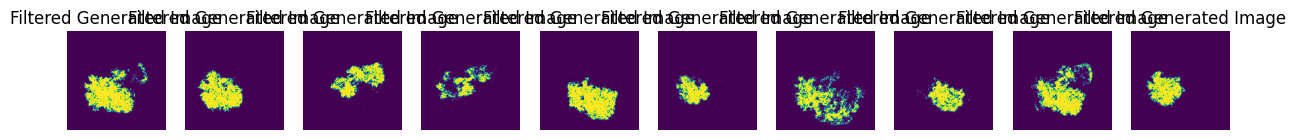

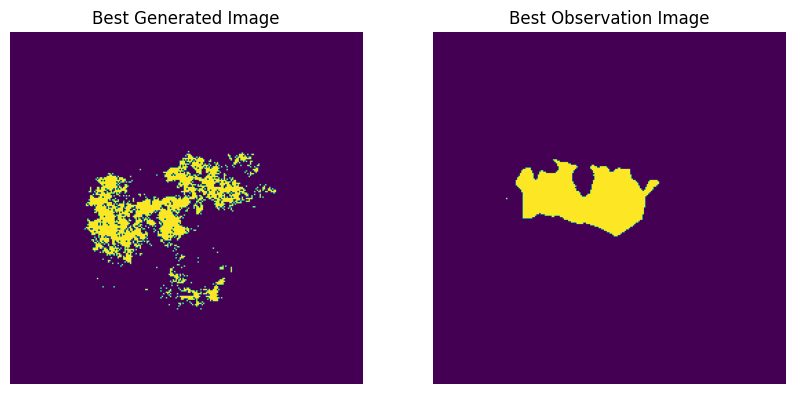

Lowest MSE: 0.0555572509765625
Best Observation Image Index: 0


In [15]:
# Example usage:
filtered_generated_images, best_generated_image, best_obs_image, best_obs_index, lowest_mse = generate_and_filter_images(
    model,
    obs_dataset,
    latent_dim=16,
    device='cpu',
    num_samples=5000,
    pixel_ratio_range=(5, 14),
    num_visualize=10,
    threshold=0.50  # Adjusted threshold value to capture slightly activated pixels
)

print(f'Lowest MSE: {lowest_mse}')
print(f'Best Observation Image Index: {best_obs_index}')

## Trying with Gaussian Smooth and SSIM Calculation

In [17]:
def generate_and_filter_images_filtered(autoencoder, obs_dataset, latent_dim=32, device='cpu', num_samples=500, pixel_ratio_range=(5, 14), num_visualize=10, threshold=0.2):
    """
    Generate images from random latent vectors and filter them based on pixel ratio criteria.

    Args:
        autoencoder (nn.Module): The VAE model.
        obs_dataset (np.ndarray): The dataset of observation images.
        latent_dim (int): Dimension of the latent space.
        device (str): The device to run the model on ('cpu' or 'cuda').
        num_samples (int): Number of images to generate from the latent space.
        pixel_ratio_range (tuple): Range of pixel activation ratio to filter generated images.
        num_visualize (int): Number of generated images to visualize.
        threshold (float): The threshold value for binarizing the generated images.

    Returns:
        filtered_generated_images (list): List of generated images that meet the pixel ratio criteria.
        best_generated_image (np.ndarray): The generated image with the lowest MSE.
        best_obs_image (np.ndarray): The observation image with the lowest MSE.
        best_obs_index (int): The index of the observation image with the lowest MSE.
        lowest_mse (float): The lowest MSE value found.
    """
    autoencoder = autoencoder.to(device)
    autoencoder.eval()

    # Generate images from latent space
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        generated_images = autoencoder.decoder(z).cpu().numpy()
    
    # Reshape generated images to 2D
    generated_images = generated_images.reshape((num_samples, 256, 256))

    # Apply Gaussian filter to smooth images
    smoothed_images = [gaussian_filter(img, sigma=1) for img in generated_images]

    # Filtered images based on pixel ratio criteria
    filtered_generated_images = []

    for i in range(num_samples):
        generated_image = smoothed_images[i].squeeze()

        # Binarize the generated image with the specified threshold
        binary_image = np.where(generated_image >= threshold, 1, 0)

        # Calculate pixel ratio
        total_pixels = np.prod(binary_image.shape)
        active_pixels = np.sum(binary_image == 1)
        pixel_ratio = (active_pixels / total_pixels) * 100

        # Debugging prints
        print(f"Generated Image {i + 1}/{num_samples}")
        print(f"Threshold: {threshold}")
        print(f"Total Pixels: {total_pixels}")
        print(f"Active Pixels: {active_pixels}")
        print(f"Pixel Ratio: {pixel_ratio:.2f}%")

        # Check if the pixel ratio is within the specified range
        if pixel_ratio_range[0] <= pixel_ratio <= pixel_ratio_range[1]:
            filtered_generated_images.append(binary_image)

    # Check if filtered images are 0 or not
    if len(filtered_generated_images) == 0:
        print('No images meet the pixel ratio criteria.')
        return None, None, None, None, None

    total_valid_generated_images = len(filtered_generated_images)
    print(f"Total Valid Generated Images: {total_valid_generated_images}")

    # Plot the filtered images
    num_visualize = min(num_visualize, len(filtered_generated_images))
    fig, ax = plt.subplots(1, num_visualize, figsize=(15, 15))
    if num_visualize == 1:
        ax.imshow(filtered_generated_images[0], cmap='viridis')
        ax.set_title("Filtered Generated Image")
        ax.axis('off')
    else:
        for i in range(num_visualize):
            ax[i].imshow(filtered_generated_images[i], cmap='viridis')
            ax[i].set_title("Filtered Generated Image")
            ax[i].axis('off')
    plt.show()

    # Initialize variables to store the lowest MSE and corresponding images
    lowest_mse = float('inf')
    highest_ssim = -1
    best_generated_image = None
    best_obs_image = None
    best_obs_index = None
    best_generated_image_idx = None

    # Iterate through generated images and compare with observation images
    for i in range(total_valid_generated_images):
        generated_image = filtered_generated_images[i]

        for j in range(len(obs_dataset)):
            obs_image = obs_dataset[j].squeeze()

            # Compute MSE
            mse = mean_squared_error(obs_image, generated_image)
            # Compute SSIM
            ssim_value = ssim(obs_image, generated_image, data_range=generated_image.max() - generated_image.min())

            # Update the best image based on combined criteria
            if mse < lowest_mse and ssim_value > highest_ssim:
                lowest_mse = mse
                highest_ssim = ssim_value
                best_generated_image = generated_image
                best_obs_image = obs_image
                best_obs_index = j
    
    # Plot the best image with the obs image side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(best_generated_image, cmap='viridis')
    ax[0].set_title("Best Generated Image")
    ax[0].axis('off')

    ax[1].imshow(best_obs_image, cmap='viridis')
    ax[1].set_title("Best Observation Image")
    ax[1].axis('off')
    plt.show()

    return filtered_generated_images, best_generated_image, best_obs_image, best_obs_index, lowest_mse

Generated Image 1/8000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 474
Pixel Ratio: 0.72%
Generated Image 2/8000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 96
Pixel Ratio: 0.15%
Generated Image 3/8000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 1156
Pixel Ratio: 1.76%
Generated Image 4/8000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 1488
Pixel Ratio: 2.27%
Generated Image 5/8000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 126
Pixel Ratio: 0.19%
Generated Image 6/8000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 1024
Pixel Ratio: 1.56%
Generated Image 7/8000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 1948
Pixel Ratio: 2.97%
Generated Image 8/8000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 6419
Pixel Ratio: 9.79%
Generated Image 9/8000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 827
Pixel Ratio: 1.26%
Generated Image 10/8000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 3719
Pixel Ratio: 5.67%
Generated Image 11/8000
Threshold:

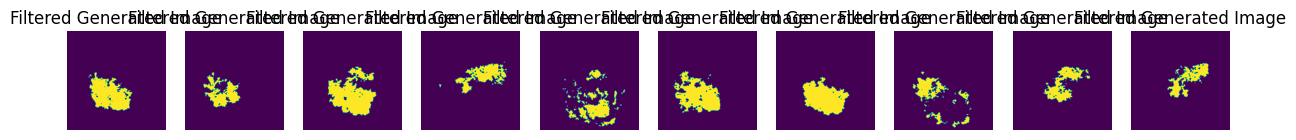

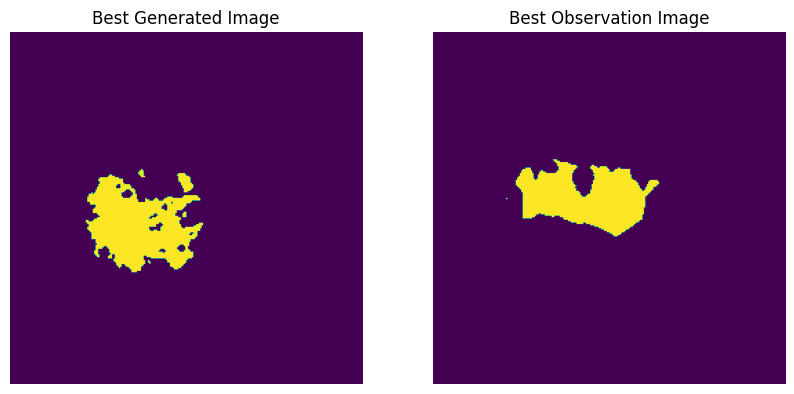

Lowest MSE: 0.060272216796875
Best Observation Image Index: 0


In [23]:
# Example usage:
filtered_generated_images, best_generated_image, best_obs_image, best_obs_index, lowest_mse = generate_and_filter_images_filtered(
    model,
    obs_dataset,
    latent_dim=16,
    device='cpu',
    num_samples=8000,
    pixel_ratio_range=(5, 14),
    num_visualize=10,
    threshold=0.60  # Adjusted threshold value to capture slightly activated pixels
)

print(f'Lowest MSE: {lowest_mse}')
print(f'Best Observation Image Index: {best_obs_index}')

## Comparing the best image with the other filtered_images

In [51]:
def generate_and_filter_images_filtered_gaus(autoencoder, obs_dataset, latent_dim=16, device='cpu', num_samples=500, pixel_ratio_range=(5, 14), num_visualize=10, threshold=0.2):
    """
    Generate images from random latent vectors and filter them based on pixel ratio criteria.

    Args:
        autoencoder (nn.Module): The VAE model.
        obs_dataset (np.ndarray): The dataset of observation images.
        latent_dim (int): Dimension of the latent space.
        device (str): The device to run the model on ('cpu' or 'cuda').
        num_samples (int): Number of images to generate from the latent space.
        pixel_ratio_range (tuple): Range of pixel activation ratio to filter generated images.
        num_visualize (int): Number of generated images to visualize.
        threshold (float): The threshold value for binarizing the generated images.

    Returns:
        filtered_generated_images (list): List of generated images that meet the pixel ratio criteria.
        best_generated_image (np.ndarray): The generated image with the lowest MSE.
        best_obs_image (np.ndarray): The observation image with the lowest MSE.
        best_obs_index (int): The index of the observation image with the lowest MSE.
        lowest_mse (float): The lowest MSE value found.
        top_10_images (list): List of the 10 generated images with the lowest MSE.
    """
    autoencoder = autoencoder.to(device)
    autoencoder.eval()

    # Generate images from latent space
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        generated_images = autoencoder.decoder(z).cpu().numpy()
    
    # Reshape generated images to 2D
    generated_images = generated_images.reshape((num_samples, 256, 256))

    # Apply Gaussian filter to smooth images
    smoothed_images = [gaussian_filter(img, sigma=1) for img in generated_images]

    # Filtered images based on pixel ratio criteria
    filtered_generated_images = []

    for i in range(num_samples):
        generated_image = smoothed_images[i].squeeze()

        # Binarize the generated image with the specified threshold
        binary_image = np.where(generated_image >= threshold, 1, 0)

        # Calculate pixel ratio
        total_pixels = np.prod(binary_image.shape)
        active_pixels = np.sum(binary_image == 1)
        pixel_ratio = (active_pixels / total_pixels) * 100

        # Debugging prints
        print(f"Generated Image {i + 1}/{num_samples}")
        print(f"Threshold: {threshold}")
        print(f"Total Pixels: {total_pixels}")
        print(f"Active Pixels: {active_pixels}")
        print(f"Pixel Ratio: {pixel_ratio:.2f}%")

        # Check if the pixel ratio is within the specified range
        if pixel_ratio_range[0] <= pixel_ratio <= pixel_ratio_range[1]:
            filtered_generated_images.append(binary_image)

    # Check if filtered images are 0 or not
    if len(filtered_generated_images) == 0:
        print('No images meet the pixel ratio criteria.')
        return None, None, None, None, None

    total_valid_generated_images = len(filtered_generated_images)
    print(f"Total Valid Generated Images: {total_valid_generated_images}")

    # Plot the filtered images
    num_visualize = min(num_visualize, len(filtered_generated_images))
    fig, ax = plt.subplots(1, num_visualize, figsize=(15, 15))
    if num_visualize == 1:
        ax.imshow(filtered_generated_images[0], cmap='viridis')
        ax.set_title("Filtered Generated Image")
        ax.axis('off')
    else:
        for i in range(num_visualize):
            ax[i].imshow(filtered_generated_images[i], cmap='viridis')
            ax[i].set_title("Filtered Generated Image")
            ax[i].axis('off')
    plt.show()

    # Initialize variables to store the lowest MSE and corresponding images
    lowest_mse = float('inf')
    highest_ssim = -1
    best_generated_image = None
    best_obs_image = None
    best_obs_index = None

    # Iterate through generated images and compare with observation images
    for i in range(total_valid_generated_images):
        generated_image = filtered_generated_images[i]

        for j in range(len(obs_dataset)):
            obs_image = obs_dataset[j].squeeze()

            # Compute MSE
            mse = mean_squared_error(obs_image, generated_image)
            # Compute SSIM
            ssim_value = ssim(obs_image, generated_image, data_range=generated_image.max() - generated_image.min())

            # Update the best image based on combined criteria
            if mse < lowest_mse and ssim_value > highest_ssim:
                lowest_mse = mse
                highest_ssim = ssim_value
                best_generated_image = generated_image
                best_obs_image = obs_image
                best_obs_index = j
    
    # Plot the best image with the obs image side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(best_generated_image, cmap='viridis')
    ax[0].set_title("Best Generated Image")
    ax[0].axis('off')

    ax[1].imshow(best_obs_image, cmap='viridis')
    ax[1].set_title("Best Observation Image")
    ax[1].axis('off')
    plt.show()

    # Compare filtered images with the best generated image
    mse_list = []
    for generated_image in filtered_generated_images:
        mse = mean_squared_error(best_generated_image, generated_image)
        mse_list.append(mse)

    # Get the indices of the 10 images with the lowest MSE
    top_10_indices = np.argsort(mse_list)[:10]
    top_10_images = [filtered_generated_images[i] for i in top_10_indices]

    # Plot the top 10 images
    fig, ax = plt.subplots(1, 10, figsize=(20, 20))
    for i in range(10):
        ax[i].imshow(top_10_images[i], cmap='viridis')
        ax[i].set_title(f"Top {i+1}")
        ax[i].axis('off')
    plt.show()

    return filtered_generated_images, best_generated_image, best_obs_image, best_obs_index, lowest_mse, top_10_images

Generated Image 1/5000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 2731
Pixel Ratio: 4.17%
Generated Image 2/5000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 853
Pixel Ratio: 1.30%
Generated Image 3/5000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 465
Pixel Ratio: 0.71%
Generated Image 4/5000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 4455
Pixel Ratio: 6.80%
Generated Image 5/5000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 2531
Pixel Ratio: 3.86%
Generated Image 6/5000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 4533
Pixel Ratio: 6.92%
Generated Image 7/5000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 707
Pixel Ratio: 1.08%
Generated Image 8/5000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 2316
Pixel Ratio: 3.53%
Generated Image 9/5000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 1947
Pixel Ratio: 2.97%
Generated Image 10/5000
Threshold: 0.6
Total Pixels: 65536
Active Pixels: 85
Pixel Ratio: 0.13%
Generated Image 11/5000
Threshold:

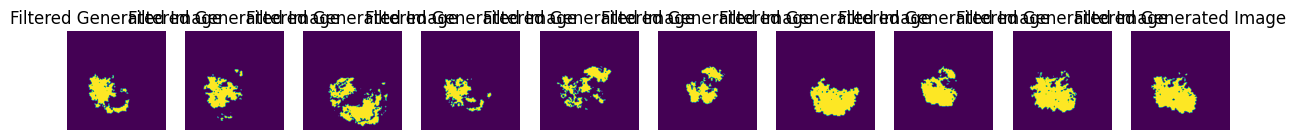

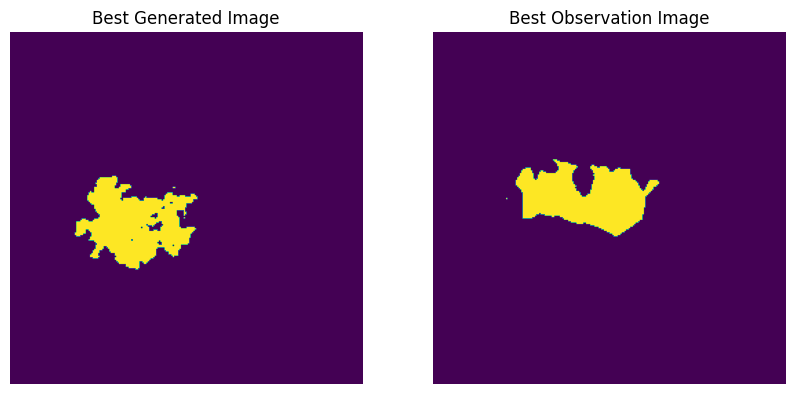

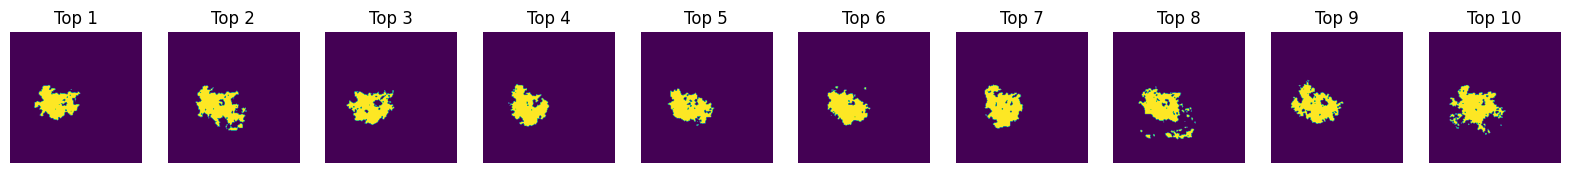

Lowest MSE: 0.05987548828125
Best Observation Image Index: 0


In [28]:
# Example usage:
filtered_generated_images, best_generated_image, best_obs_image, best_obs_index, lowest_mse, top_10_images = generate_and_filter_images_filtered(
    model,
    obs_dataset,
    latent_dim=16,
    device='cpu',
    num_samples=8000,
    pixel_ratio_range=(5, 14),
    num_visualize=10,
    threshold=0.60  # Adjusted threshold value to capture slightly activated pixels
)

print(f'Lowest MSE: {lowest_mse}')
print(f'Best Observation Image Index: {best_obs_index}')

In [ ]:
# save the top 10 images as numpy arrays
for i, img in enumerate(top_10_images):
    np.save(f"top_10_image_{i}.npy", img)

# Current working function

In [85]:
def generate_and_filter_images_filtered(autoencoder, obs_dataset, latent_dim=16, device='cpu', num_samples=500, pixel_ratio_range=(5, 14), num_visualize=10, threshold=0.2, print_info=False):
    """
    Generate images from random latent vectors and filter them based on pixel ratio criteria.

    Args:
        autoencoder (nn.Module): The VAE model.
        obs_dataset (np.ndarray): The dataset of observation images.
        latent_dim (int): Dimension of the latent space.
        device (str): The device to run the model on ('cpu' or 'cuda').
        num_samples (int): Number of images to generate from the latent space.
        pixel_ratio_range (tuple): Range of pixel activation ratio to filter generated images.
        num_visualize (int): Number of generated images to visualize.
        threshold (float): The threshold value for binarizing the generated images.

    Returns:
        filtered_generated_images (list): List of generated images that meet the pixel ratio criteria.
        best_generated_image (np.ndarray): The generated image with the lowest MSE.
        best_obs_image (np.ndarray): The observation image with the lowest MSE.
        best_obs_index (int): The index of the observation image with the lowest MSE.
        lowest_mse (float): The lowest MSE value found.
        top_10_images (list): List of the 10 generated images with the lowest MSE.
        top_10_mses (list): List of the MSE values of the top 10 generated images.
    """
    autoencoder = autoencoder.to(device)
    autoencoder.eval()

    # Generate images from latent space
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        generated_images = autoencoder.decoder(z).cpu().numpy()
    
    # Reshape generated images to 2D
    generated_images = generated_images.reshape((num_samples, 256, 256))

    # Apply Gaussian filter to smooth images
    smoothed_images = [gaussian_filter(img, sigma=1) for img in generated_images]

    # Filtered images based on pixel ratio criteria
    filtered_generated_images = []

    for i in range(num_samples):
        generated_image = smoothed_images[i].squeeze()

        # Binarize the generated image with the specified threshold
        binary_image = np.where(generated_image >= threshold, 1, 0)

        # Calculate pixel ratio
        total_pixels = np.prod(binary_image.shape)
        active_pixels = np.sum(binary_image == 1)
        pixel_ratio = (active_pixels / total_pixels) * 100

        if print_info:
        # Debugging prints
            print(f"Generated Image {i + 1}/{num_samples}")
            print(f"Threshold: {threshold}")
            print(f"Total Pixels: {total_pixels}")
            print(f"Active Pixels: {active_pixels}")
            print(f"Pixel Ratio: {pixel_ratio:.2f}%")

        # Check if the pixel ratio is within the specified range
        if pixel_ratio_range[0] <= pixel_ratio <= pixel_ratio_range[1]:
            filtered_generated_images.append(binary_image)

    # Check if filtered images are 0 or not
    if len(filtered_generated_images) == 0:
        print('No images meet the pixel ratio criteria.')
        return None, None, None, None, None, None, None

    total_valid_generated_images = len(filtered_generated_images)
    print(f"Total Valid Generated Images: {total_valid_generated_images}")

    # # Plot the filtered images
    # num_visualize = min(num_visualize, len(filtered_generated_images))
    # fig, ax = plt.subplots(1, num_visualize, figsize=(15, 15))
    # if num_visualize == 1:
    #     ax.imshow(filtered_generated_images[0], cmap='viridis')
    #     ax.set_title("Filtered Generated Image")
    #     ax.axis('off')
    # else:
    #     for i in range(num_visualize):
    #         ax[i].imshow(filtered_generated_images[i], cmap='viridis')
    #         ax[i].set_title("Filtered Generated Image")
    #         ax[i].axis('off')
    # plt.show()

    # Initialize variables to store the lowest MSE and corresponding images
    lowest_mse = float('inf')
    highest_ssim = -1
    best_generated_image = None
    best_obs_image = None
    best_obs_index = None

    # Iterate through generated images and compare with observation images
    for i in range(total_valid_generated_images):
        generated_image = filtered_generated_images[i]

        for j in range(len(obs_dataset)):
            obs_image = obs_dataset[j].squeeze()

            # Compute MSE
            mse = mean_squared_error(obs_image, generated_image)
            # Compute SSIM
            ssim_value = ssim(obs_image, generated_image, data_range=generated_image.max() - generated_image.min())

            # Update the best image based on combined criteria
            if mse < lowest_mse and ssim_value > highest_ssim:
                lowest_mse = mse
                highest_ssim = ssim_value
                best_generated_image = generated_image
                best_obs_image = obs_image
                best_obs_index = j
    
    # Plot the best image with the obs image side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(best_generated_image, cmap='viridis')
    ax[0].set_title("Best Generated Image")
    ax[0].axis('off')

    ax[1].imshow(best_obs_image, cmap='viridis')
    ax[1].set_title("Best Observation Image")
    ax[1].axis('off')
    plt.show()

    # Compare filtered images with the best generated image
    mse_list = []
    for generated_image in filtered_generated_images:
        mse = mean_squared_error(best_generated_image, generated_image)
        mse_list.append(mse)
    
    #get the top 100 images
    top_indices = np.argsort(mse_list)[:100]
    top_images = [filtered_generated_images[i] for i in top_indices]
    top_mses = [mse_list[i] for i in top_indices]

    # top_indices = np.argsort(mse_list)[:60]
    # top_images = [filtered_generated_images[i] for i in top_indices]
    # top_mses = [mse_list[i] for i in top_images]

    # Plot the top 60 images with MSE values
    fig, ax = plt.subplots(10, 10, figsize=(30, 30))
    for i in range(10):
        for j in range(10):
            idx = i * 10 + j
            ax[i, j].imshow(top_images[idx], cmap='viridis')
            ax[i, j].set_title(f"MSE: {top_mses[idx]:.2f}")
            ax[i, j].axis('off')

    return filtered_generated_images, best_generated_image, best_obs_image, best_obs_index, lowest_mse, top_images, top_mses

Total Valid Generated Images: 1256


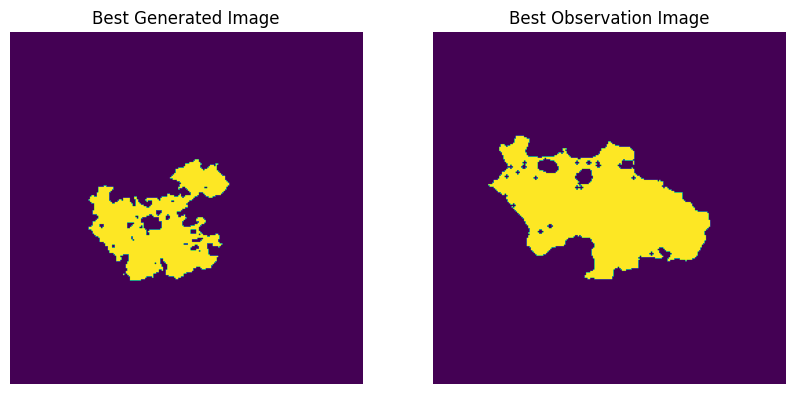

Lowest MSE: 0.09906005859375


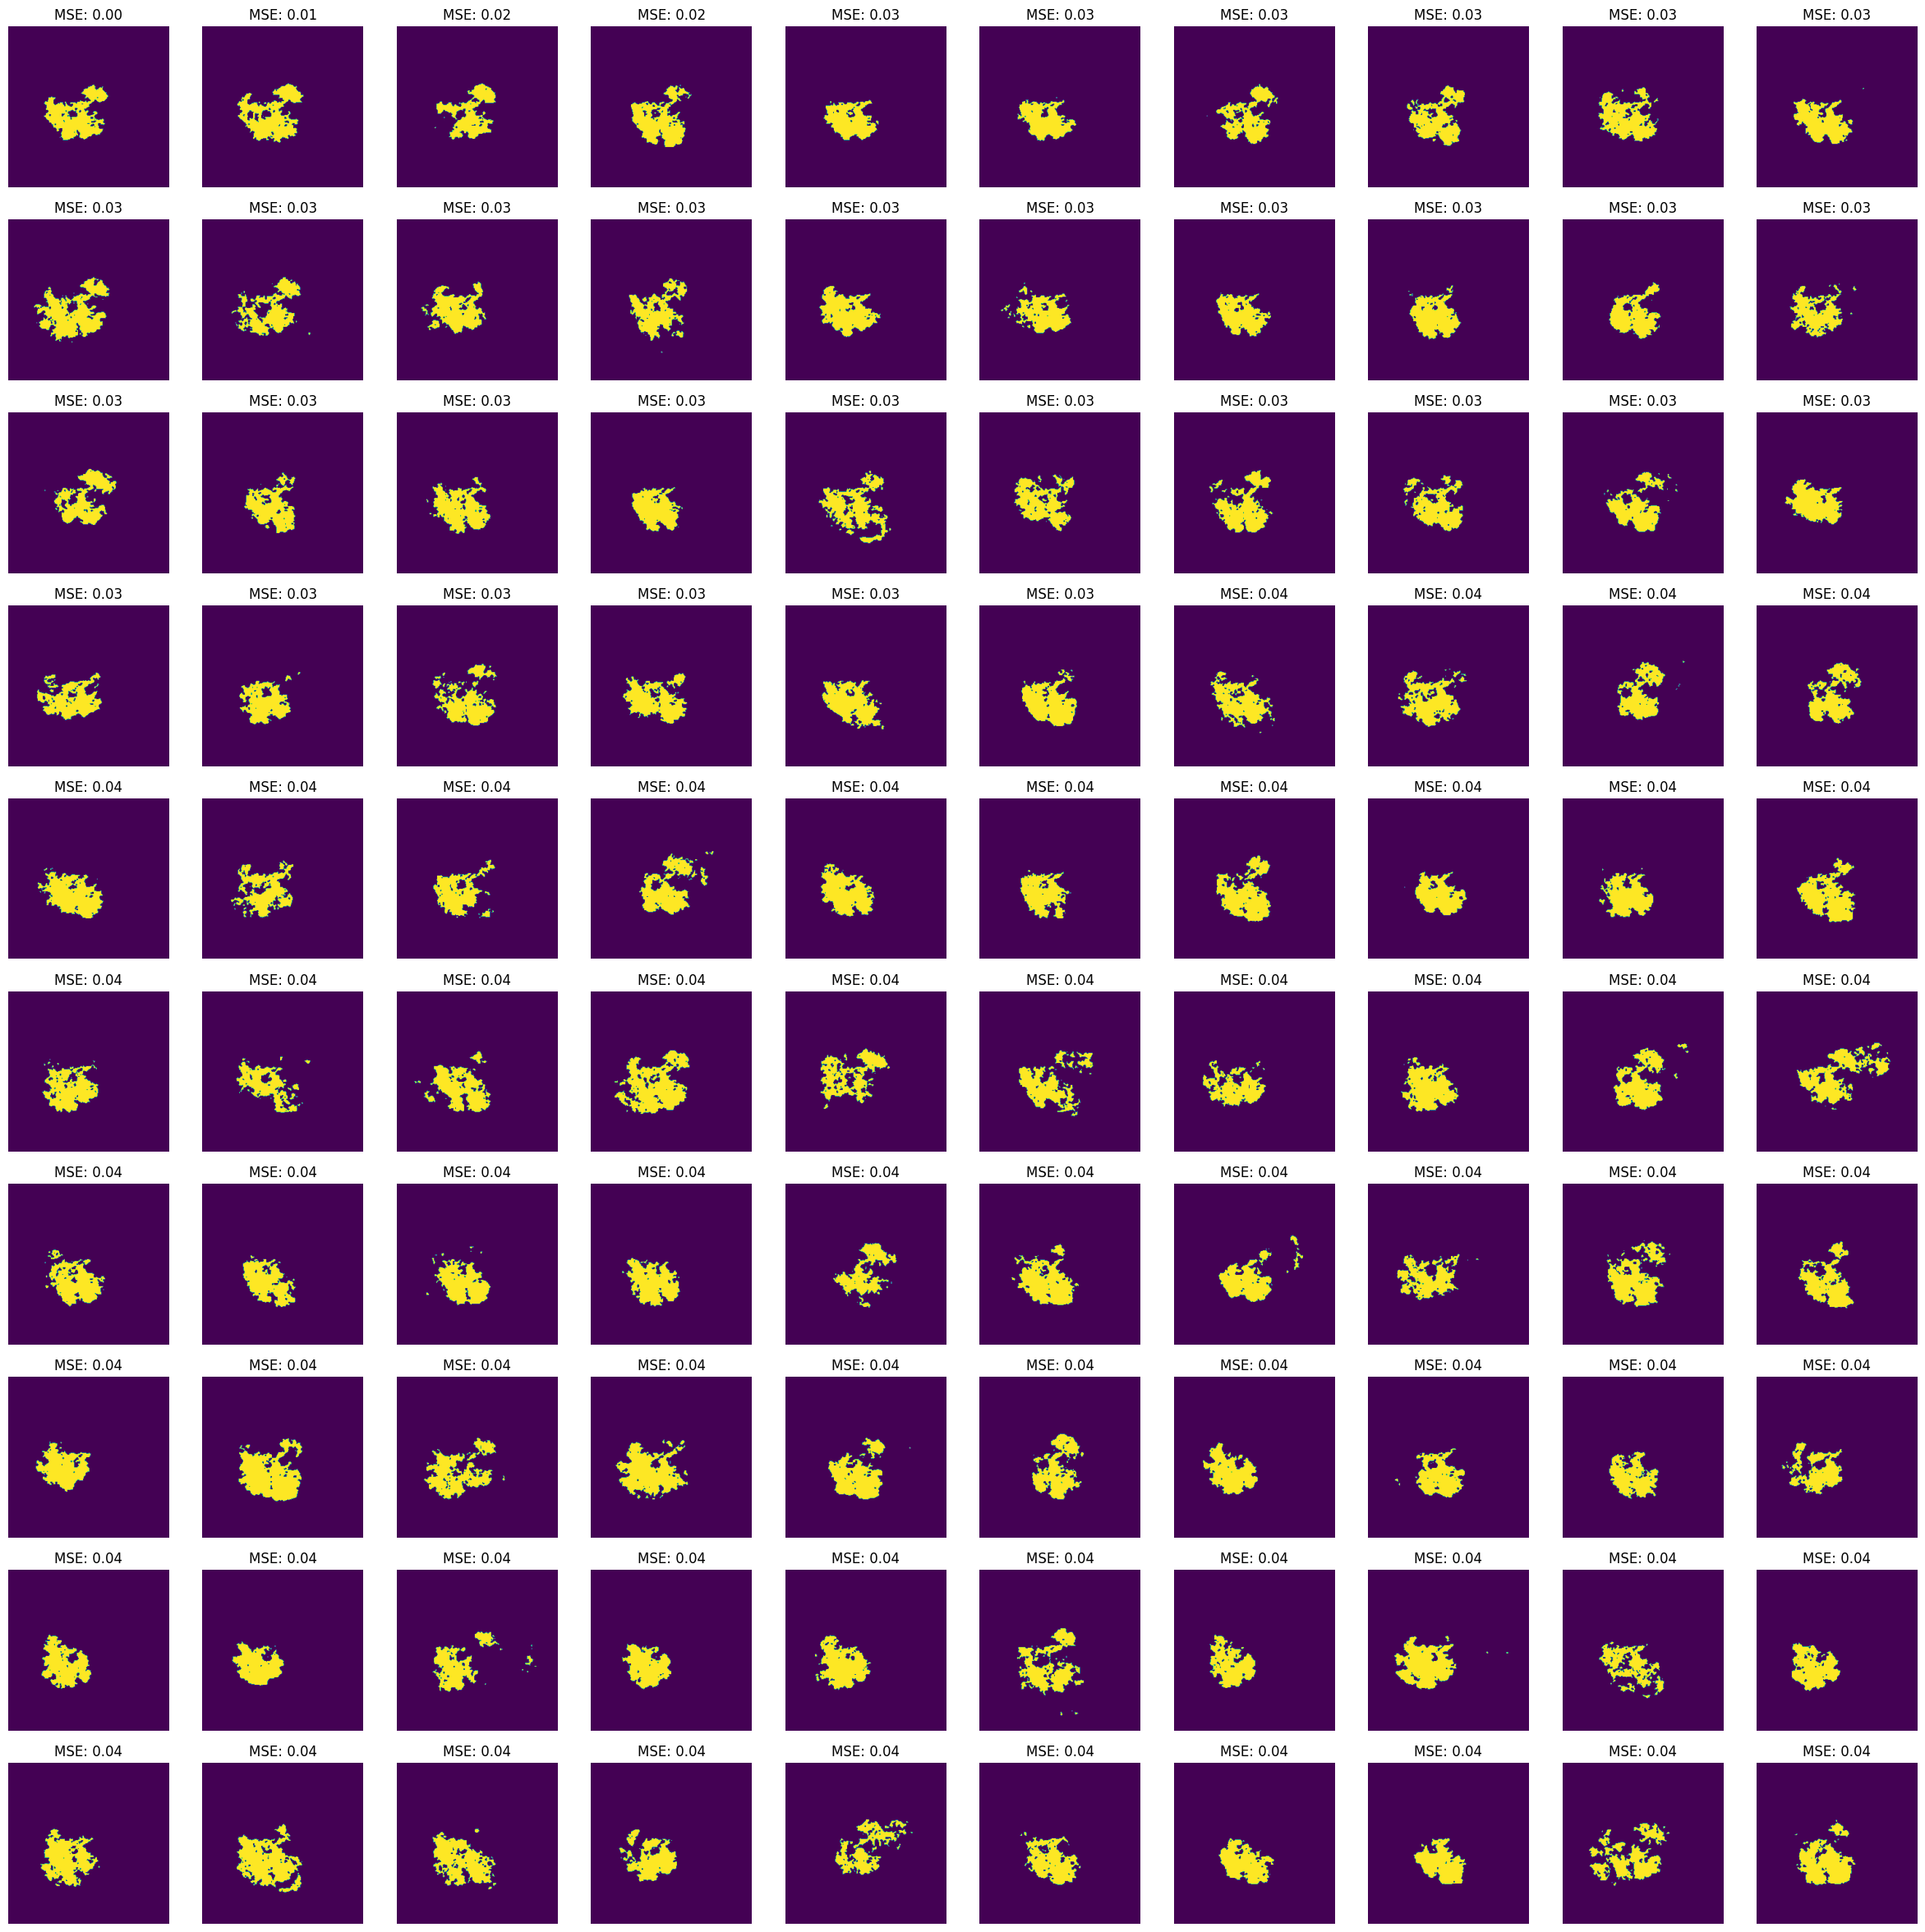

In [86]:
# Example usage:
filtered_generated_images, best_generated_image, best_obs_image, best_obs_index, lowest_mse, top_images, top_mses = generate_and_filter_images_filtered(
    model,
    obs_dataset_last,
    latent_dim=16,
    device='cpu',
    num_samples=10000,
    pixel_ratio_range=(5, 14),
    num_visualize=10,
    threshold=0.70 # Can adjust threshold
)

print(f'Lowest MSE: {lowest_mse}')

In [87]:
# Save the extracted images
best_100 = np.array(top_images)

# Save the extracted images
np.save(f"top_background_100.npy", best_100)

In [90]:
best_generated_image.shape

(256, 256)

In [88]:
np.save(f"best_background_assimilate_2.npy", best_generated_image)

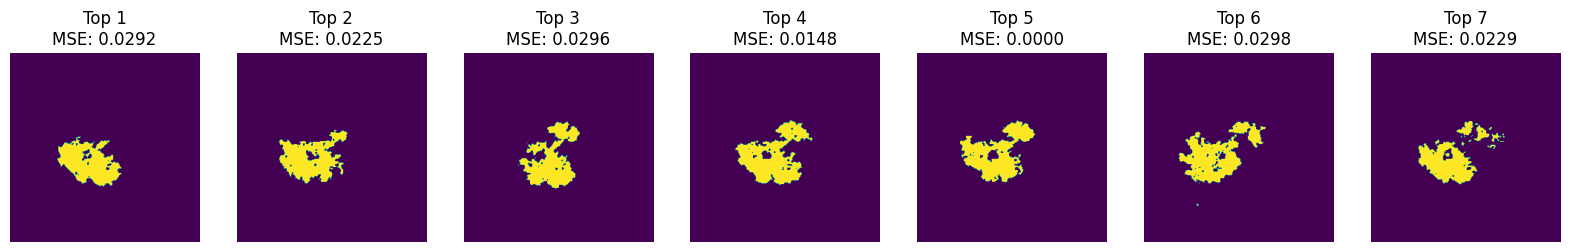

In [39]:
# order
idx_plot = [7, 2, 8, 1, 0, 9, 3]
# plot top 10 images
fig, ax = plt.subplots(1, 7, figsize=(20, 20))
for i, idx in enumerate(idx_plot):
    ax[i].imshow(top_10_images[idx], cmap='viridis')
    ax[i].set_title(f"Top {i+1}\nMSE: {top_10_mses[idx]:.4f}")
    ax[i].axis('off')


In [43]:
extracted_images = np.array(top_10_images)[idx_plot]

# Save the extracted images
np.save(f"top_background_images.npy", extracted_images)

# Save the best image separately
np.save(f"best_background_assimilate.npy", best_generated_image)

In [ ]:
# # Save the top 10 images as numpy arrays
# os.makedirs('top_10_images', exist_ok=True)
# for i, img in enumerate(top_10_images):
#     np.save(f'top_10_images/top_{i+1}_mse_{top_10_mses[i]:.4f}.npy', img)

In [ ]:
# Ensure the directory exists
os.makedirs('top_10_images', exist_ok=True)

# Combine the top 10 images into a single NumPy array
combined_top_10_images = np.stack(top_10_images)

# Save the combined array as a single .npy file
np.save('top_10_images/top_10_images.npy', combined_top_10_images)

# # Optionally, you can also save the MSE values separately if needed
# np.save('top_10_images/top_10_mses.npy', np.array(top_10_mses))

# Trying the function without the Gaussian Blur

In [48]:
def generate_and_filter_images_filtered(autoencoder, obs_dataset, latent_dim=16, device='cpu', num_samples=500, pixel_ratio_range=(5, 14), num_visualize=10, threshold=0.2, print_info=False):
    """
    Generate images from random latent vectors and filter them based on pixel ratio criteria.

    Args:
        autoencoder (nn.Module): The VAE model.
        obs_dataset (np.ndarray): The dataset of observation images.
        latent_dim (int): Dimension of the latent space.
        device (str): The device to run the model on ('cpu' or 'cuda').
        num_samples (int): Number of images to generate from the latent space.
        pixel_ratio_range (tuple): Range of pixel activation ratio to filter generated images.
        num_visualize (int): Number of generated images to visualize.
        threshold (float): The threshold value for binarizing the generated images.

    Returns:
        filtered_generated_images (list): List of generated images that meet the pixel ratio criteria.
        best_generated_image (np.ndarray): The generated image with the lowest MSE.
        best_obs_image (np.ndarray): The observation image with the lowest MSE.
        best_obs_index (int): The index of the observation image with the lowest MSE.
        lowest_mse (float): The lowest MSE value found.
        top_10_images (list): List of the 10 generated images with the lowest MSE.
        top_10_mses (list): List of the MSE values of the top 10 generated images.
    """
    autoencoder = autoencoder.to(device)
    autoencoder.eval()

    # Generate images from latent space
    z = torch.randn(num_samples, latent_dim).to(device)
    with torch.no_grad():
        generated_images = autoencoder.decoder(z).cpu().numpy()
    
    # Reshape generated images to 2D
    generated_images = generated_images.reshape((num_samples, 256, 256))

    # # Apply Gaussian filter to smooth images
    # smoothed_images = [gaussian_filter(img, sigma=1) for img in generated_images]

    # Filtered images based on pixel ratio criteria
    filtered_generated_images = []

    for i in range(num_samples):
        generated_image = generated_images[i].squeeze()

        # Binarize the generated image with the specified threshold
        binary_image = np.where(generated_image >= threshold, 1, 0)

        # Calculate pixel ratio
        total_pixels = np.prod(binary_image.shape)
        active_pixels = np.sum(binary_image == 1)
        pixel_ratio = (active_pixels / total_pixels) * 100

        if print_info:
            # Debugging prints
            print(f"Generated Image {i + 1}/{num_samples}")
            print(f"Threshold: {threshold}")
            print(f"Total Pixels: {total_pixels}")
            print(f"Active Pixels: {active_pixels}")
            print(f"Pixel Ratio: {pixel_ratio:.2f}%")

        # Check if the pixel ratio is within the specified range
        if pixel_ratio_range[0] <= pixel_ratio <= pixel_ratio_range[1]:
            filtered_generated_images.append(binary_image)

    # Check if filtered images are 0 or not
    if len(filtered_generated_images) == 0:
        print('No images meet the pixel ratio criteria.')
        return None, None, None, None, None, None, None

    total_valid_generated_images = len(filtered_generated_images)
    print(f"Total Valid Generated Images: {total_valid_generated_images}")

    # Plot the filtered images
    num_visualize = min(num_visualize, len(filtered_generated_images))
    fig, ax = plt.subplots(1, num_visualize, figsize=(15, 15))
    if num_visualize == 1:
        ax.imshow(filtered_generated_images[0], cmap='viridis')
        ax.set_title("Filtered Generated Image")
        ax.axis('off')
    else:
        for i in range(num_visualize):
            ax[i].imshow(filtered_generated_images[i], cmap='viridis')
            ax[i].set_title("Filtered Generated Image")
            ax[i].axis('off')
    plt.show()

    # Initialize variables to store the lowest MSE and corresponding images
    lowest_mse = float('inf')
    highest_ssim = -1
    best_generated_image = None
    best_obs_image = None
    best_obs_index = None

    # Iterate through generated images and compare with observation images
    for i in range(total_valid_generated_images):
        generated_image = filtered_generated_images[i]

        for j in range(len(obs_dataset)):
            obs_image = obs_dataset[j].squeeze()

            # Compute MSE
            mse = mean_squared_error(obs_image, generated_image)
            # Compute SSIM
            ssim_value = ssim(obs_image, generated_image, data_range=generated_image.max() - generated_image.min())

            # Update the best image based on combined criteria
            if mse < lowest_mse and ssim_value > highest_ssim:
                lowest_mse = mse
                highest_ssim = ssim_value
                best_generated_image = generated_image
                best_obs_image = obs_image
                best_obs_index = j
    
    # Plot the best image with the obs image side by side
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(best_generated_image, cmap='viridis')
    ax[0].set_title("Best Generated Image")
    ax[0].axis('off')

    ax[1].imshow(best_obs_image, cmap='viridis')
    ax[1].set_title("Best Observation Image")
    ax[1].axis('off')
    plt.show()

    # Compare filtered images with the best generated image
    mse_list = []
    for generated_image in filtered_generated_images:
        mse = mean_squared_error(best_generated_image, generated_image)
        mse_list.append(mse)

    # Get the indices of the 10 images with the lowest MSE
    top_10_indices = np.argsort(mse_list)[:10]
    top_10_images = [filtered_generated_images[i] for i in top_10_indices]
    top_10_mses = [mse_list[i] for i in top_10_indices]

    # Plot the top 10 images
    fig, ax = plt.subplots(1, 10, figsize=(20, 20))
    for i in range(10):
        ax[i].imshow(top_10_images[i], cmap='viridis')
        ax[i].set_title(f"Top {i+1}\nMSE: {top_10_mses[i]:.4f}")
        ax[i].axis('off')
    plt.show()

    return filtered_generated_images, best_generated_image, best_obs_image, best_obs_index, lowest_mse, top_10_images, top_10_mses

Total Valid Generated Images: 1710


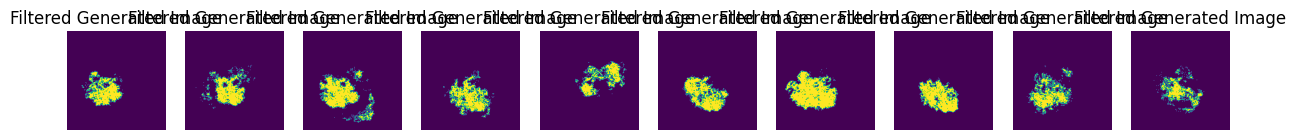

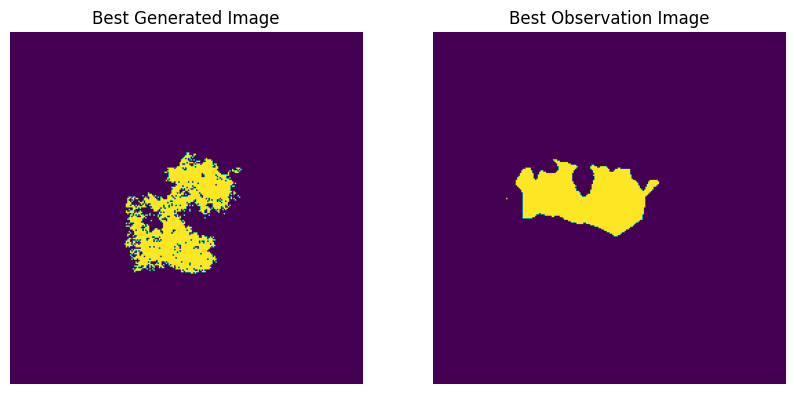

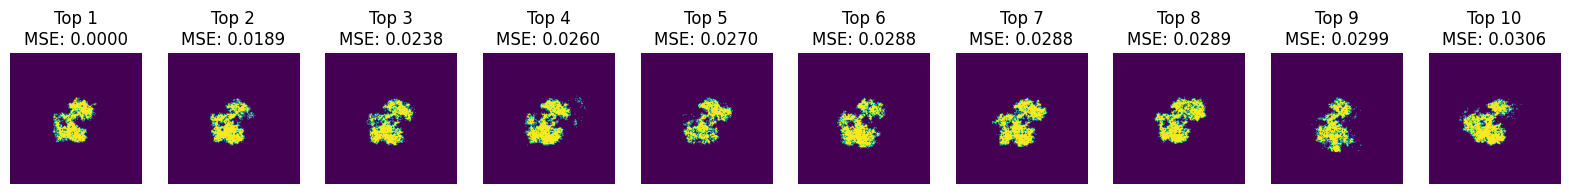

In [49]:
# Example usage:
filtered_generated_images, best_generated_image, best_obs_image, best_obs_index, lowest_mse, top_10_images, top_10_mses = generate_and_filter_images_filtered(
    model,
    obs_dataset,
    latent_dim=16,
    device='cpu',
    num_samples=10000,
    pixel_ratio_range=(5, 14),
    num_visualize=10,
    threshold=0.65,
    print_info=False)# Can adjust threshold

In [ ]:
# 